# Вариант 2. 
## Задание 1
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 
### Какие данные у нас есть?
* ID 
* Принадлежность тестовой/контрольной группе
* Информация об оплатах пользователей в дни проведения эксперимента
* Информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

### Что мы можем узнать?
* Conversion rate в платежи в группе А и Б. Нужно понять повлияла ли новая механика оплаты на конверсию в платежи.
* Сравнить платежи в группе А и Б

## Подготовка датафреймов, первый анализ

1. Импортируем библиотеки
2. pd.read_csv
3. пишем функцию чтобы по ней чекать все датафреймы
4. джойним дату
5. Exploratory data analysis 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
from statsmodels.stats.contingency_tables import StratifiedTable
from scipy import stats
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from tqdm.auto import tqdm
from scipy.stats import norm

plt.style.use('ggplot')

import pandahouse as ph


Populating the interactive namespace from numpy and matplotlib


In [57]:
def df_stat_desc(x):
    columns = x.shape[1]
    rows = x.shape[0]
    col_name = x.columns
    isna = x.isna().sum()
    print(f'Датафрейм содержит {columns} колонок и {rows} строк', end = '\n')
    print(f'Названия колонок : {col_name}', sep = '\n')
    print(f'Пропущеные значения в колонках : {isna}', sep = '\n')
    return x.head()
#функция для описания датафреймов

In [8]:
groups = pd.read_csv('Проект_2_groups.csv', sep = ';' )
checks = pd.read_csv('Проект_2_checks.csv', sep = ';' ,header = 0, names=['id', 'rev'])
active_studs = pd.read_csv('Проект_2_active_studs.csv', sep = ';' ,header = 0, names=['id'])
# сразу для удобства меняем название колонок

In [59]:
df_stat_desc(groups)


Датафрейм содержит 2 колонок и 74484 строк
Названия колонок : Index(['id', 'grp'], dtype='object')
Пропущеные значения в колонках : id     0
grp    0
dtype: int64


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [60]:
df_stat_desc(checks) 


Датафрейм содержит 2 колонок и 541 строк
Названия колонок : Index(['id', 'rev'], dtype='object')
Пропущеные значения в колонках : id     0
rev    0
dtype: int64


,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [61]:
df_stat_desc(active_studs)


Датафрейм содержит 1 колонок и 8341 строк
Названия колонок : Index(['id'], dtype='object')
Пропущеные значения в колонках : id    0
dtype: int64


,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [62]:
active_ab = active_studs.merge(groups, on = 'id') # df для тех, кто попал в тест
df_stat_desc(active_ab)


Датафрейм содержит 2 колонок и 8328 строк
Названия колонок : Index(['id', 'grp'], dtype='object')
Пропущеные значения в колонках : id     0
grp    0
dtype: int64


,id,grp
0,581585,A
1,3276743,B
2,4238589,A
3,4475369,B
4,5481015,B


In [63]:
print(active_studs.nunique() - active_ab.nunique())


grp     NaN
id     13.0
dtype: float64


#### Есть 13 человек, которые были на сайте во время теста, но им не была присовена группа А или Б. Их мы не можем учитывать в нашем эксперименте, поэтому отсекаем

### Странно что в тестовой группе намного больше людей, чем в контрольной. Но это не должно нам помешать в стат исследовании


In [64]:
act_plus_checks = active_ab.merge(checks, on = 'id', how = 'left') #добавляем платежи 
df_stat_desc(act_plus_checks)

Датафрейм содержит 3 колонок и 8328 строк
Названия колонок : Index(['id', 'grp', 'rev'], dtype='object')
Пропущеные значения в колонках : id        0
grp       0
rev    7937
dtype: int64


,id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN


In [65]:
act_plus_checks.rev.describe()

count     391.000000
mean     1191.544766
std       827.421317
min       199.000000
25%       290.000000
50%       990.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [66]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

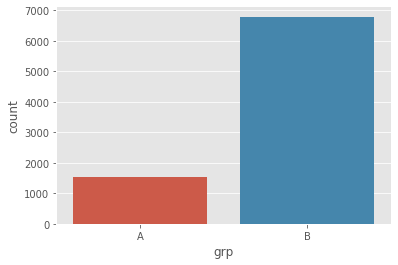

In [67]:
sns.countplot(x = 'grp', data = act_plus_checks)


### В checks 541 оплата, в df c id принявшими участие в эксперименте всего 391 оплата. Но  нас интересуют только те id, которые попали в эксперимент

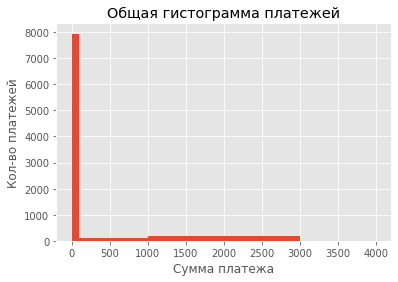

In [68]:
act_plus_checks = act_plus_checks.fillna(0) # replace NaN with 0 

fix, ax = plt.subplots()
ax.hist(act_plus_checks['rev'], bins = [0,100, 500, 1000, 3000, 4000]) #step - thin lines
ax.set_ylabel('Кол-во платежей')
ax.set_xlabel('Сумма платежа')
ax.set_title('Общая гистограмма платежей')
plt.show()

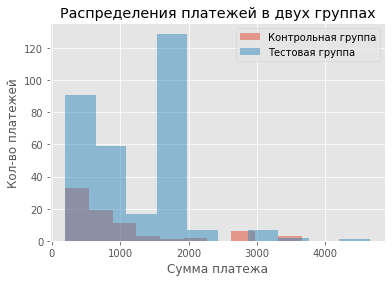

In [69]:
act_plus_checks_paid = act_plus_checks.query('rev > 0')#оставляем только платящих пользователей

fix, ax = plt.subplots() #смортим распределение платежей 
ax.hist(act_plus_checks_paid.query('grp == "A"')['rev'], label = 'Контрольная группа', alpha = 0.5) #step - thin lines
ax.hist(act_plus_checks_paid.query('grp == "B"')['rev'], label = 'Тестовая группа', alpha = 0.5)
ax.set_title('Распределения платежей в двух группах')
ax.set_ylabel('Кол-во платежей')
ax.set_xlabel('Сумма платежа')
ax.legend()
plt.show()

In [70]:
act_plus_checks_paid.query('grp == "A"').rev.value_counts()

290.0     25
580.0      6
990.0      5
590.0      5
199.0      5
690.0      4
1530.0     3
3660.0     3
840.0      3
1140.0     2
489.0      2
1160.0     2
2820.0     2
2910.0     2
2890.0     1
1180.0     1
2900.0     1
1830.0     1
2220.0     1
870.0      1
398.0      1
1980.0     1
1039.0     1
Name: rev, dtype: int64

In [71]:
act_plus_checks_paid.query('grp == "B"').rev.value_counts()

1900.0000    92
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
590.0000      6
398.0000      6
870.0000      5
580.0000      5
1530.0000     5
2890.0000     3
2099.0000     3
1980.0000     2
3660.0000     2
2910.0000     2
796.0000      1
1388.0000     1
489.0000      1
1160.0000     1
2190.0000     1
3040.0000     1
1968.0000     1
880.0000      1
1729.0000     1
2220.0000     1
1339.0000     1
4650.0000     1
1050.0000     1
597.0000      1
3260.0000     1
Name: rev, dtype: int64

In [72]:
print(act_plus_checks_paid.query("rev == '1900.0000' or rev == '1900.0001'").rev.sum())
print(act_plus_checks_paid.query('grp == "B"').rev.sum())
print(act_plus_checks_paid.query("rev == '1900.0000' or rev == '1900.0001'").rev.sum()/
      act_plus_checks_paid.query('grp == "B"').rev.sum())

241300.00350000002
393074.0035
0.6138793238713891


In [73]:
act_plus_checks_paid.query("rev == '1900.0000' or rev == '1900.0001'").rev.count()

127

## Выводы:
* В тесте участвовало намного больше человек из тестовой группы чем из контрольной
* Большая часть платежей равна 0
* Платежей было на 150шт больше, чем в файле с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. Следовательно не все оплаты попадают в наш анализ
* Распределение платежей в группе А и Б - ненормально
* Существует большое кол-во одинаковых значений в колонке rev(интересен 1900 и 1900.0001 в 'B'). 
* Непонятна природа этих платежей. Мы делали новую платежную систему и ожидаем более-менее равномерного конверсии, а у нас появилось большое кол-во платежей на одну сумму. Выглядит как промоакция, которая появилась на сайте только у группы Б. Также смущает 1 десятитысячная в оплате, больше нигде такого нету, суммы кругые.
* Должны различаться только системы оплаты, но ,скорее всего, это не так. У нас не хватает информации чтобы установить природу этих платежей. 
* Странно отрезать значения, которые составляют больше половины от всех платежей. И на выходе будут сложноинтерпретируемые выводы. 
* Тем не менее мы можем постараться эмперически решить этот вопрос. Мы посчитаем arpu, arpau, медиану для всех данных и для данных, которые мы скорректируем. Дальше мы посчитаем стат значимость различий в группах и на осоновании результатов будем решать какой вывод делать

## Начнем со сравнения платежей в группах
* ARPU
* ARPAU
* Медиана платежей в группах
* Статзначимость различий


### Новая механика оплаты может оказать прямое влияние на конверию(например упрощена оплата и не нужно вводить данные карты, т.е. путь от корзины до оплаты сокращается). Также можем предположить что новая механика оплаты может как-то сказаться на среднем чеке(например доп товары по скидке не только в корзине, но и в окне оплаты)
### Так как точной информации по новой системе платежей у нас нету, то нужно проверить все гипотезы
* Считаем ARPU, ARPAU и медиану платежей для всех данных и для данных где мы уберем 'подозрительные' платежи 


In [74]:
arpu = act_plus_checks.groupby('grp')['rev'].describe()['mean'].round(2)
print(f'Для необработаных данных ARPU  группы А = {arpu[0]} ,ARPU группы B = {arpu[1]} ')
arppu = act_plus_checks_paid.groupby('grp')['rev'].describe()['mean'].round(2)
print(f'Для необработаных данных ARPPU группы А = {arppu[0]},ARPU группы B = {arppu[1]} ')

Для необработаных данных ARPU  группы А = 47.44 ,ARPU группы B = 57.86 
Для необработаных данных ARPPU группы А = 933.59,ARPU группы B = 1255.83 


In [75]:
median_paying = act_plus_checks_paid.groupby('grp')['rev'].describe()['50%'].round(2)
print(f'Для необработаных данных медианный платеж на платящего человека группы А = {median_paying[0]}, Медианный платеж на платящего человека  группы B = {median_paying[1]} ')

Для необработаных данных медианный платеж на платящего человека группы А = 585.0, Медианный платеж на платящего человека  группы B = 1140.0 


In [76]:
#здесь отрезаем "странные" платежи
act_plus_checks_correct = act_plus_checks.query("rev != '1900.0000' and rev != '1900.0001'")
act_plus_checks_paid_correct = act_plus_checks_paid.query("rev != '1900.0000' and rev != '1900.0001'")
arpu = act_plus_checks_correct.groupby('grp')['rev'].describe()['mean'].round(2)
print(f'Для обработанных данных ARPU  группы А = {arpu[0]} ,ARPU группы B = {arpu[1]} ')
arppu = act_plus_checks_paid_correct.groupby('grp')['rev'].describe()['mean'].round(2)
print(f'Для обработанных данных ARPPU группы А = {arppu[0]},ARPU группы B = {arppu[1]} ')

Для обработанных данных ARPU  группы А = 47.44 ,ARPU группы B = 22.77 
Для обработанных данных ARPPU группы А = 933.59,ARPU группы B = 815.99 


In [77]:
median_paying = act_plus_checks_paid_correct.groupby('grp')['rev'].describe()['50%'].round(2)
print(f'Для обработанных данных медианный платеж на платящего человека группы А = {median_paying[0]}, Медианный платеж на платящего человека  группы B = {median_paying[1]} ')

Для обработанных данных медианный платеж на платящего человека группы А = 585.0, Медианный платеж на платящего человека  группы B = 690.0 


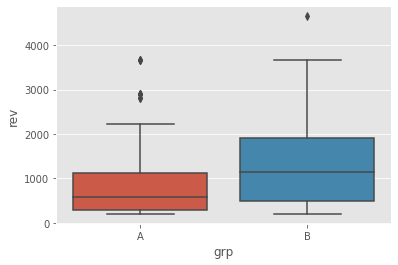

In [78]:
#боксплот с оригинальными данными
sns.boxplot(x = 'grp', y = 'rev', data = act_plus_checks_paid)

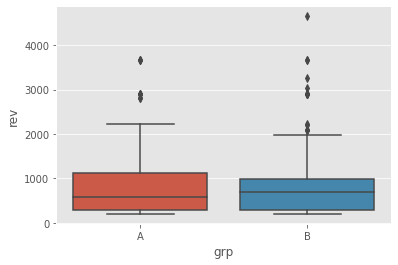

In [79]:
#боксплот с обработанными данными
sns.boxplot(x = 'grp', y = 'rev', data = act_plus_checks_paid_correct)

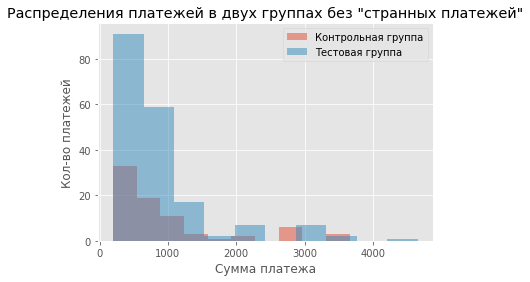

In [87]:
fix, ax = plt.subplots() #смортим распределение платежей 
ax.hist(act_plus_checks_paid_correct.query('grp == "A"')['rev'], label = 'Контрольная группа', alpha = 0.5) #step - thin lines
ax.hist(act_plus_checks_paid_correct.query('grp == "B"')['rev'], label = 'Тестовая группа', alpha = 0.5)
ax.set_title('Распределения платежей в двух группах без "странных платежей"')
ax.set_ylabel('Кол-во платежей')
ax.set_xlabel('Сумма платежа')
ax.legend()
plt.show()

#### ARPU, ARPAU, MEDIAN и BOXPLOT  с оригинальными данными указывают на то, что группа Б платит намного больше
#### ARPU, ARPAU и BOXPLOT  с обработаными данными  напротив указывают на то, что группа А платит больше, но медиана в Б все еще выше, хотя и не настолько

### Статзначимость
* T-Test фейлится из-за выбросов, а они у нас есть (1900 и 1900.0001 в 'B') и результат может ввести нас в заблуждение. Можно прологарифмировать, но тогда не сможем сделать внятных выводов(ttest сравнивает по средним, но после логарифмирования сможем сделать вывод о логарифмированых данных, а не реальных). Просто проведем shapiro на нормальность распределения, чтобы точно отмести ttest. 
* Хотя непараметрика (манна-уитни) нормально работает с ассимеричными данными, он плохо работает с большим кол-вом повторяющихся значений. Также по непараметрике очень сложно сделать конкретные выводы, тк она сравнивает ранги значений. Тоже не идеальный вариант
* Bootstrap позволяет понять где различия в группах (медиана, процентили). Проблема в том, что нужна репрезентативная качественная выборка. Если мы считаем что она таковой и является, то это лучший вариант.

## Н0 - rev в наших группах статзначимо не различается

In [88]:
sp = stats.shapiro(act_plus_checks_paid.query('grp == "A"')['rev'])
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = stats.shapiro(act_plus_checks_paid.query('grp == "B"')['rev'])
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения target группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

Тест на нормальность распределения control группы: W = 0.735 , p-value = 0.000 => стат значимо не нормально
Тест на нормальность распределения target группы: W = 0.855 , p-value = 0.000 => стат значимо не нормально


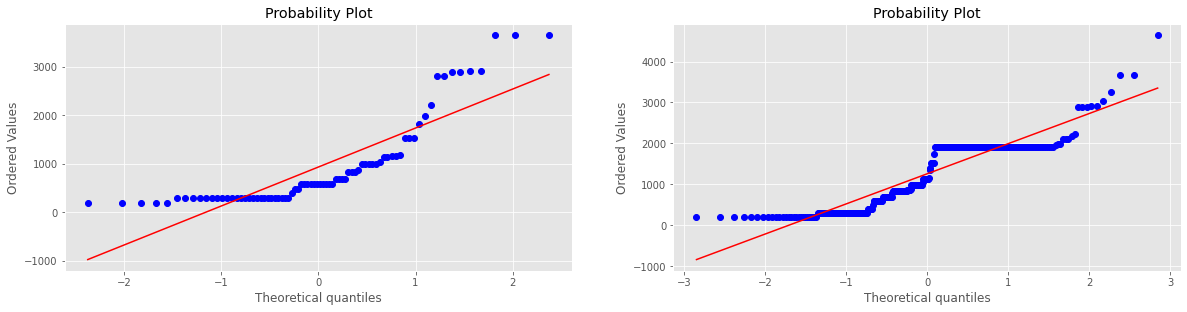

In [89]:
pylab.figure(figsize=(20,10))
pylab.subplot(2,2,1)
stats.probplot(act_plus_checks_paid.query('grp == "A"')['rev'], dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(act_plus_checks_paid.query('grp == "B"')['rev'], dist="norm", plot=pylab)
pylab.show()

### Тест Шапиро-Уилка и qq-plot говорят о том, распределение метрики в группе не нормально

### Создадим функцию и проведем bootstrap наших оригинальных данных и подкорректированых

In [90]:
def get_bootstrap( # создаем функцию для бутстрапа
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {
            "quants": quants, 
            "p_value": p_value}

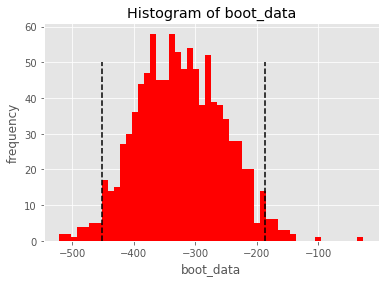

{'quants':                 0
 0.025 -451.518141
 0.975 -186.256163,
 'p_value': 3.624130391845512e-06}

In [91]:
# бутсрапируем оригинальные данные
get_bootstrap(
    act_plus_checks_paid[act_plus_checks_paid.grp == 'A']['rev'] , # числовые значения первой выборки
    act_plus_checks_paid[act_plus_checks_paid.grp == 'B']['rev'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)



### Тут через Bootstrap я считал средние оригинальных данных. На гистограме можно наблюдать разницу бутстрапированых средних группы А и Б. Так как в наши 95% не попадает 0 по оси Х, то даже по гистограме можно отклонить Н0. Глядя на результирующий P-value мы можем смело отклонить Н0 и принять альтернативную гипотезу.
### Итого принимаем Н1 о том, что наши контрольные группы не равны. И можем сказать что наша новая система оплаты статистически значимо положительно сказалась на показателях rev.

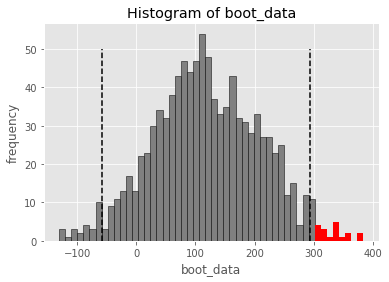

{'quants':                 0
 0.025  -58.724328
 0.975  293.988844,
 'p_value': 0.1818684727838964}

In [92]:
# бутсрапируем измененные данные
get_bootstrap(
    act_plus_checks_paid_correct[act_plus_checks_paid_correct.grp == 'A']['rev'] , # числовые значения первой выборки
    act_plus_checks_paid_correct[act_plus_checks_paid_correct.grp == 'B']['rev'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

### Тут через Bootstrap я считал средние измененных данных. На гистограме можно обнаружить что в наши 95%  попадает 0 по оси Х. Глядя на результирующий P-value мы должны оставить Н0 о том, что наши контрольные группы  равны. 

#### На выходе у нас информация, которая противоречит друг другу

## Разбираемся с conversion rate:
* Создадим кросстаблицу (А/Б)/(Оплатил/не оплатил) для двух видов данных(ориг и измененные)
* Так как у нас будет 2 номинативные переменные, то можем применить хи-квадрат.


In [93]:
def paid_func(act_plus_checks): #функция для создания номинативной переменной платежей
    if (act_plus_checks['rev'] == 0):
        return 'no'
    else:
        return 'yes'
act_plus_checks['paid'] = act_plus_checks.apply(paid_func, axis = 1)
strat_df = act_plus_checks.drop(columns = ['id', 'rev'])
strat_df.tail()

,grp,paid
8323,B,no
8324,B,no
8325,B,no
8326,B,yes
8327,B,no


In [94]:
def paid_func(act_plus_checks_correct): #функция для создания номинативной переменной платежей
    if (act_plus_checks_correct['rev'] == 0):
        return 'no'
    else:
        return 'yes'
act_plus_checks_correct['paid'] = act_plus_checks_correct.apply(paid_func, axis = 1)
strat_df_c = act_plus_checks_correct.drop(columns = ['id', 'rev'])
strat_df_c.tail()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,grp,paid
8323,B,no
8324,B,no
8325,B,no
8326,B,yes
8327,B,no


In [95]:
cross_c = pd.crosstab(strat_df_c.grp, strat_df_c.paid) #кросстаб для измененных данных
cross_c

paid,no,yes
grp,,
A,1457,78
B,6480,186


In [96]:
percent_cross_c = pd.crosstab(strat_df_c.grp, strat_df_c.paid, normalize = 'index').style.format('{:.2%}') 
percent_cross_c #конверсия для измененных данных

paid,no,yes
grp,,
A,94.92%,5.08%
B,97.21%,2.79%


In [97]:
cross = pd.crosstab(strat_df.grp, strat_df.paid) #кросстаб для ориг данных
cross

paid,no,yes
grp,,
A,1457,78
B,6480,313


In [98]:
percent_cross = pd.crosstab(strat_df.grp, strat_df.paid, normalize = 'index').style.format('{:.2%}') 
percent_cross #конверсия для ориг данных

paid,no,yes
grp,,
A,94.92%,5.08%
B,95.39%,4.61%


### В колонке paid/yes можем наблюдать конверсию. 5.08% для группы А и 4.61% для группы Б для оригинальных данных и 5.08% для группы А и 2.79% для группы Б для измененных

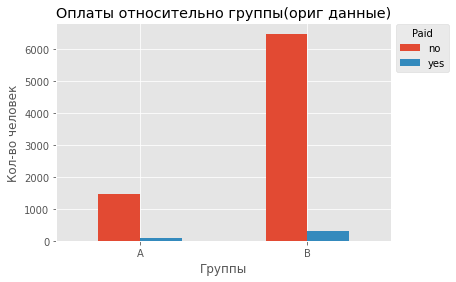

In [99]:
ax = cross.plot(kind='bar',  rot=0)
ax.set_ylabel('Кол-во человек')
ax.set_xlabel('Группы')
ax.set_title('Оплаты относительно группы(ориг данные)')
ax.legend(title='Paid', bbox_to_anchor=(1, 1.02), loc='upper left')

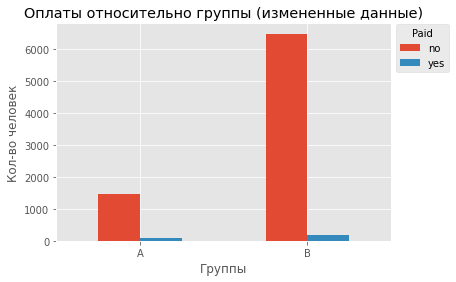

In [100]:
ax = cross_c.plot(kind='bar',  rot=0)
ax.set_ylabel('Кол-во человек')
ax.set_xlabel('Группы')
ax.set_title('Оплаты относительно группы (измененные данные)')
ax.legend(title='Paid', bbox_to_anchor=(1, 1.02), loc='upper left')

In [101]:
stat, p, dof, expected  = chi2_contingency(cross) #критерий хи-квадрат
print(f'Для оригинальной таблицы P-value по хи-квадрат = {p}')

Для оригинальной таблицы P-value по хи-квадрат = 0.46803677583199144


In [102]:
stat, p, dof, expected  = chi2_contingency(cross_c) #критерий хи-квадрат
print(f'Для измененной таблицы P-value по хи-квадрат = {p}')

Для измененной таблицы P-value по хи-квадрат = 6.641749986515503e-06


### В оригинальных данных критерий Хи-квадрат дал  P-value, намного превышающий 5% уровень значимости. Это не позволяет нам  отклонять Н0 о том, что конверсия в группах статзначимо различается. B измененных данных наоборот P-value дает статзначимые различия в этих группах.

#### Опять противоречивые выводы

### Итого я делаю вывод что А/Б тест проведен с рядом ошибок:
* Контрольная группа в несколько раз меньше экспериментальной (это не критично, но странно раскатывать новую систему оплаты на ≈70% аудитории сайта)
* 150 оплат и следоватльно их ID отсутствуют в df с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента, следовательно из 541 оплаты в checks мы оставляем 391, а из них 127 оплат 'странные'
* Самое важное - огромное кол-во платежей на одинаковую сумму в контрольной группе без какого-либо объяснения 
* Мы можем выдвинуть 2 гипотезы: 
    * у тестовой группы на сайте появилась промоакция, которой не было у контрольной и это полностью ломает эксперимент
    * в новую механику оплаты услуг входит что-то помимо новой механики оплаты услуг
* У нас нету информации чтобы подвердить или опровергнуть любую из этих гипотез, поэтому на основании этого А/Б теста не следует делать никаких выводов и стоит провести эксперимент корректно

___________
# Задание 2

In [20]:
#объявляем параметры подключения
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

## Часть 1 - кол-во активных студентов

In [21]:
query = """
SELECT COUNT (active_students) AS number_of_act_stud
FROM(
    SELECT DISTINCT st_id AS active_students
    FROM peas
    WHERE MONTH(`timest`) = '10' AND YEAR(`timest`) = '2021'
    GROUP BY active_students
    HAVING SUM(correct) > 20)
"""  
task_1 = ph.read_clickhouse(query, connection=connection_default)
task_1

,number_of_act_stud
0,130


In [22]:
# в задании требовался текущий месяц, поэтому оставлю запрос и на текущий месяц
query = """
SELECT COUNT (active_students) AS number_of_act_stud
FROM(
    SELECT DISTINCT st_id AS active_students
    FROM peas
    WHERE MONTH(`timest`) = MONTH(NOW()) AND YEAR(`timest`) = YEAR(NOW())
    GROUP BY active_students
    HAVING SUM(correct) > 20)
"""  
task_1_2 = ph.read_clickhouse(query, connection=connection_default)
task_1_2

,number_of_act_stud
0,0


## Часть 2
### Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
* ARPU считается относительно всех пользователей, попавших в группы.

#### Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

#### Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [23]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
/* все будем выполнять через Common table expression (CTE) */ 
/* в числитель CR берем уникальные транзакции, но считаем count(distinct st_id),
так как мы считаем st_id из таблицы с final_project_check и uniqExact(st_id) = уникальному 
платежу
В знаменатель CR берем общее кол-во студентов в зависимости от критерия СR */ 
----------------
/* считаем кол-во всех студентов для ARPU и CR */ 
WITH stu AS (    
    SELECT  COUNT(DISTINCT st_id) AS total_stud,
            test_grp
    FROM studs
    GROUP BY test_grp
),
/* считаем кол-во всех платежей от активных пользователей по математике для math_cr */ 
math_act_paym AS (    
    SELECT COUNT(DISTINCT st_id) AS total_payments_math_stud,
           test_grp
    FROM default.final_project_check AS f
    LEFT JOIN studs AS s
    ON s.st_id = f.st_id
    WHERE st_id IN (
            SELECT 
                DISTINCT p.st_id
            FROM peas AS p
            LEFT JOIN studs AS s
            ON p.st_id = s.st_id
            GROUP BY st_id
            HAVING SUM(correct) >= 2 AND subject = 'Math') AS a
    GROUP BY test_grp
),
/* считаем все кол-во платежей для CR */ 
money AS (    
    SELECT COUNT (DISTINCT st_id) AS total_payments,
            s.test_grp
    FROM default.final_project_check AS f
    LEFT JOIN studs AS s
    ON f.st_id = s.st_id
    GROUP BY test_grp
),
/* счиатем сумму всех денег для ARPU */ 
money_sum AS (
SELECT SUM(f.money) AS total_money_sum,
            s.test_grp
    FROM default.final_project_check AS f
    LEFT JOIN studs AS s
    ON f.st_id = s.st_id
    GROUP BY test_grp
),
/* считаем все кол-во платежей от активных студентов для act_cr */ 
act_paym AS (    
    SELECT COUNT (DISTINCT st_id) AS total_payments_act_stud,
           test_grp
    FROM default.final_project_check AS f
    LEFT JOIN studs AS s
    ON s.st_id = f.st_id
    WHERE st_id IN (
            SELECT 
                DISTINCT p.st_id
            FROM peas AS p
            LEFT JOIN studs AS s
            ON p.st_id = s.st_id
            GROUP BY st_id
            HAVING SUM(correct) > 10) AS a
    GROUP BY test_grp
),
/* считаем все кол-во акт студентов для act_cr */ 
act_stud_tot AS (
    SELECT COUNT(DISTINCT st_id) AS total_act_st,
    test_grp
    FROM (
            SELECT 
                DISTINCT p.st_id
                FROM peas AS p
                LEFT JOIN studs AS s
                ON p.st_id = s.st_id
                GROUP BY st_id
                HAVING SUM(correct) > 10)AS a
    LEFT JOIN studs AS s
    ON a.st_id = s.st_id
    GROUP BY test_grp
),
/* считаем все кол-во активных студентов по математике для math_cr */ 
act_math_tot AS (
    SELECT COUNT(DISTINCT st_id) AS total_math_stud,
    test_grp
    FROM (
            SELECT 
                DISTINCT p.st_id
                FROM peas AS p
                LEFT JOIN studs AS s
                ON p.st_id = s.st_id
                GROUP BY st_id
                HAVING SUM(correct) >= 2 AND subject = 'Math') AS a
    LEFT JOIN studs AS s
    ON a.st_id = s.st_id
    GROUP BY test_grp
),
/* считаем кол-во денег от активных студентов */ 
arpau AS
    (SELECT SUM(money) AS total_act_st_money_sum,
               test_grp
        FROM default.final_project_check AS f
        LEFT JOIN studs AS s
        ON s.st_id = f.st_id
        WHERE st_id IN (
                SELECT 
                    DISTINCT p.st_id
                FROM peas AS p
                LEFT JOIN studs AS s
                ON p.st_id = s.st_id
                GROUP BY st_id
                HAVING SUM(correct) > 10) AS a
        GROUP BY test_grp)
----------------
SELECT 
    stu.test_grp AS group,
    ROUND(total_money_sum / total_stud,2)AS ARPU,
    ROUND(total_act_st_money_sum / total_act_st, 2) AS ARPAU,
    ROUND(total_payments / total_stud * 100, 2) AS CR,
    ROUND(total_payments_act_stud / total_act_st * 100, 2) AS act_CR,
    ROUND(total_payments_math_stud / total_math_stud * 100, 2) AS math_CR
FROM act_paym
LEFT JOIN money
ON act_paym.test_grp = money.test_grp
LEFT JOIN math_act_paym
ON act_paym.test_grp = math_act_paym.test_grp
LEFT JOIN stu 
ON act_paym.test_grp = stu.test_grp
LEFT JOIN money_sum 
ON act_paym.test_grp = money_sum.test_grp
LEFT JOIN act_stud_tot
ON act_paym.test_grp = act_stud_tot.test_grp
LEFT JOIN act_math_tot
ON act_paym.test_grp = act_math_tot.test_grp
LEFT JOIN arpau 
ON act_paym.test_grp = arpau.test_grp
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,group,ARPU,ARPAU,CR,act_CR,math_CR
0,control,4540.98,10393.70,4.92,11.02,10.20
1,pilot,11508.47,29739.58,10.85,26.04,14.29


# Задание 3
* Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
* Реализуйте функцию, которая будет строить графики по получаемым метрикам.

## Первая функция выводит на печать:
* Конверсия
* ARPU
* ARPPU
* Медианный платеж
* Актуальную дату получения информации


In [9]:
from datetime import date
def update_df(x): 
    """Функция для обновления данных в датафрейме, в агрумент функции - местоположение датафрейма для присоединения
    На выходе получаем ARPU, ARPAU, медиану платежей и актуальную дату"""
    groups_add = pd.read_csv(x, sep = ',') # считываем дату
    active_studs = pd.read_csv('Проект_2_active_studs.csv', sep = ';' ,header = 0, names=['id'])
    groups = pd.read_csv('Проект_2_groups.csv', sep = ';' )
    checks = pd.read_csv('Проект_2_checks.csv', sep = ';' ,header = 0, names=['id', 'rev'])
    up_full_groups = pd.concat([groups, groups_add], axis = 0) #соедин 2 датафрейма
    up_active_ab = active_studs.merge(up_full_groups, on = 'id') # нас интересуют только те, кто попал в тест
    up_act_plus_checks = up_active_ab.merge(checks, on = 'id', how = 'left') # прикрепляем платежи
    up_act_plus_checks = up_act_plus_checks.fillna(0) # убираем NaN из даты
    up_act_plus_checks_paid = up_act_plus_checks.query('rev > 0')
    up_conv_paid = up_act_plus_checks_paid.groupby('grp')['rev'].count().reset_index()
    up_conv_all = up_act_plus_checks.groupby('grp')['rev'].count().reset_index()
    up_conv_all['conversion'] = round(up_conv_paid['rev'] / up_conv_all['rev'] * 100, 2) # count converison
    up_conv_print = print('Конверсия группы А = ', up_conv_all['conversion'][0],'%', '\n','Конверсия группы B = ', up_conv_all['conversion'][1],'%') #print
    up_arpu = up_act_plus_checks.groupby('grp')['rev'].describe()['mean'].round(2) # обсчитываем ARPU
    up_arpu_print = print(f'ARPU группы А = {up_arpu[0]},ARPU группы B = {up_arpu[1]} ')
    up_arppu = up_act_plus_checks_paid.groupby('grp')['rev'].describe()['mean'].round(2)# обсчитываем ARPPU
    up_arppu_print = print(f'ARPPU группы А = {up_arppu[0]},ARPPU группы B = {up_arppu[1]} ')
    up_median_paying = up_act_plus_checks_paid.groupby('grp')['rev'].describe()['50%'].round(2) # смотрим медиану
    up_median_paying_print = print(f'Медианный платеж на платящего человека группы А = {up_median_paying[0]},Медианный платеж на платящего человека  группы B = {up_median_paying[1]} ')
    time = date.today()
    print(f'Актуальная дата {time}'),
    print(up_conv_print),
    print(up_arpu_print),
    print(up_arppu_print),
    print(up_median_paying_print)
    return up_act_plus_checks, up_active_ab, up_act_plus_checks_paid  
# возвращаем датафреймы с новыми данными пользователя для последующей рабоыт с ними

In [10]:
up_act_plus_checks, up_active_ab, up_act_plus_checks_paid = update_df('Проект_2_group_add.csv') 
# смортим интересующие нас показатели

Конверсия группы А =  5.07 % 
 Конверсия группы B =  4.62 %
ARPU группы А = 47.35,ARPU группы B = 58.06 
ARPPU группы А = 933.59,ARPPU группы B = 1257.88 
Медианный платеж на платящего человека группы А = 585.0,Медианный платеж на платящего человека  группы B = 1140.0 
Актуальная дата 2022-11-07
None
None
None
None


In [11]:
print(update_df.__doc__)

Функция для обновления данных в датафрейме, в агрумент функции - местоположение датафрейма для присоединения
    На выходе получаем ARPU, ARPAU, медиану платежей и актуальную дату


In [32]:
def update_df_plot(up_act_plus_checks, up_active_ab, up_act_plus_checks_paid): 
    """Aргументы функции - датасеты,которые мы получили из предыдущей функции. 
    На выходе получаем обновленные графики по нашим данным """
    
    time = date.today()
    
    plt.figure(figsize = (8,8))
    fix, ax = plt.subplots()
    ax.hist(up_active_ab['grp'], bins = 3) #step - thin lines
    ax.set_ylabel('Кол-во человек в группе')
    ax.set_xlabel('Группы')
    ax.set_title(f'Распределение человек по группам на {time}')
    ab_distribution = plt.show()
    
    fix, ax = plt.subplots()
    ax.hist(up_act_plus_checks['rev'], bins = [0,100, 500, 1000, 3000, 4000]) #step - thin lines
    ax.set_ylabel('Кол-во платежей')
    ax.set_xlabel('Размер платежа')
    ax.set_title(f'Общая гистограмма платежей на {time}')
    payments_hist = plt.show()    
    
    fix, ax = plt.subplots() #смортим распределение платежей 
    ax.hist(up_act_plus_checks_paid.query('grp == "A"')['rev'], label = 'Контрольная группа', alpha = 0.5) #step - thin lines
    ax.hist(up_act_plus_checks_paid.query('grp == "B"')['rev'], label = 'Тестовая группа', alpha = 0.5)
    ax.set_title(f'Распределения платежей в двух группах на {time}')
    ax.set_ylabel('Кол-во платежей')
    ax.set_xlabel('Размер платежа')
    ax.legend()
    payment_distribution = plt.show()
    
    boxplot_distribution = sns.boxplot(x = 'grp', y = 'rev', data = up_act_plus_checks_paid)
    

    return ab_distribution,payments_hist,payment_distribution, boxplot_distribution

<Figure size 576x576 with 0 Axes>

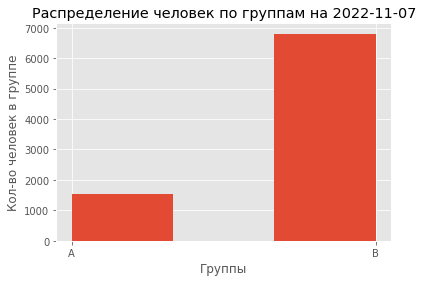

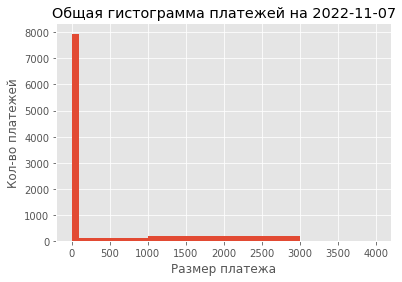

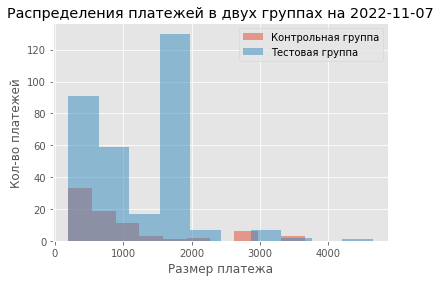

(None, None, None, <matplotlib.axes._subplots.AxesSubplot at 0x7ffae4db2860>)

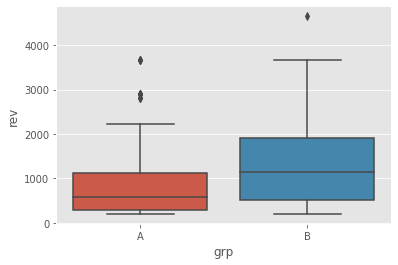

In [33]:
update_df_plot(up_act_plus_checks, up_active_ab, up_act_plus_checks_paid)
# графики на актуальную дату использования функции

In [34]:
print(update_df_plot.__doc__)

Aргументы функции - датасеты,которые мы получили из предыдущей функции. 
    На выходе получаем обновленные графики по нашим данным 
